In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='data/seg_train', transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.ImageFolder(root='data/seg_test', transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


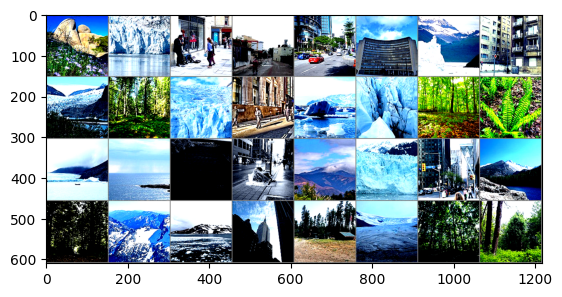

In [24]:
from torchvision.utils import make_grid, save_image

for images, labels in train_loader:
    def imshow(img):
        img = img / 2 + 0.5 
        np_img = img.numpy()
        plt.imshow(np.transpose(np_img, (1, 2, 0)))
        plt.show()

    imshow(torchvision.utils.make_grid(images))
    break

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Adjusted input channels and kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Adjusted kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.drop_out = nn.Dropout()

        # Calculate the input size for the first fully connected layer based on the new image size (150x150)
        self.fc_input_size = 64 * 37 * 37  # 64 channels, 37x37 spatial dimensions after two max-pooling layers

        self.fc1 = nn.Linear(self.fc_input_size, 100)
        self.fc2 = nn.Linear(100, 6)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
lowest_val_loss = float('inf')

In [12]:
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad() 
        outputs = model(inputs) 
        loss = criterion(outputs, targets)
        loss.backward()  
        optimizer.step() 

    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in train_loader:  
            outputs = model(inputs) 
            validation_loss += criterion(outputs, targets).item()  

    validation_loss /= len(train_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}')

torch.save(model.state_dict(), 'model.pth')

Epoch [1/10], Loss: 1.1324, Validation Loss: 0.8329
Epoch [2/10], Loss: 0.7093, Validation Loss: 0.6573
Epoch [3/10], Loss: 1.0424, Validation Loss: 0.5606
Epoch [4/10], Loss: 0.3018, Validation Loss: 0.4296
Epoch [5/10], Loss: 0.5719, Validation Loss: 0.3914
Epoch [6/10], Loss: 0.2770, Validation Loss: 0.2565
Epoch [7/10], Loss: 0.2353, Validation Loss: 0.1876
Epoch [8/10], Loss: 0.0116, Validation Loss: 0.2581
Epoch [9/10], Loss: 0.3647, Validation Loss: 0.1361
Epoch [10/10], Loss: 0.3087, Validation Loss: 0.0895


In [25]:
model.load_state_dict(torch.load('model.pth'))

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {(correct / total) * 100:.2f}%')

Accuracy: 79.18%
